In [44]:
import itertools
from multiprocessing.dummy import Pool as ThreadPool 
from tqdm import tqdm
# istarmap.py for Python <3.8
import multiprocessing.pool as mpp


def istarmap(self, func, iterable, chunksize=1):
    """starmap-version of imap
    """
    if self._state != mpp.RUN:
        raise ValueError("Pool not running")

    if chunksize < 1:
        raise ValueError(
            "Chunksize must be 1+, not {0:n}".format(
                chunksize))

    task_batches = mpp.Pool._get_tasks(func, iterable, chunksize)
    result = mpp.IMapIterator(self._cache)
    self._taskqueue.put(
        (
            self._guarded_task_generation(result._job,
                                          mpp.starmapstar,
                                          task_batches),
            result._set_length
        ))
    return (item for chunk in result for item in chunk)


mpp.Pool.istarmap = istarmap

def fast(function,inputs,num_processes=4):
    print("-------------------------------")
    print(f"Running {num_processes} processes")
    pool = ThreadPool(num_processes)

    for _ in tqdm(pool.istarmap(function, inputs),
                        total=len(inputs)):
        pass


    
    # pool.starmap(function,tqdm(inputs))

    print("\n\n\n\n\n-------------------------------")
    print(f"All processes run")

In [49]:
# convert a midi file to wav
# construct a midi file with pitch, velocity, note length

from copy import deepcopy
from miditoolkit.midi import parser as mid_parser  
from miditoolkit.midi import containers as ct

import pyloudnorm as pyln
import soundfile as sd
import numpy as np
import subprocess
from tqdm import tqdm
from pydub import AudioSegment


store_mido_obj = mid_parser.MidiFile("temp.mid")

def midi2mp3(midi_file,mp3_file):
    cmmnd=f"timidity -Ow -o - {midi_file} | lame - {mp3_file}"
    subprocess.call(cmmnd,shell=True)
    return(mp3_file)

def mp32wav(mp3_file,wav_file):
    sound = AudioSegment.from_mp3(mp3_file)
    sound.export(wav_file, format="wav")

def midi2wav(midi_file,wav_file):
    # create mp3 file
    mp3_file="Store/Notes/temp_mp3.mp3"
    midi2mp3(midi_file,mp3_file)

    mp32wav(mp3_file,wav_file)

    return(wav_file)

def createNoteMidi(pitch, velocity, note_length, tempo=120, program=0, is_drum=False):
    mido_obj=deepcopy(store_mido_obj)
    # delete all the notes
    for track in mido_obj.instruments:
        track.notes = []

    # create a note
    note = ct.Note(start=0, end=note_length, pitch=pitch, velocity=velocity)

    # add the note to the first track
    mido_obj.instruments[0].notes.append(note)

    return(mido_obj)

def createNoteAudio(pitch,velocity,note_length):
    mido_obj=createNoteMidi(pitch,velocity,note_length)
    filename=f"Store/Notes/temp.mid"
    mido_obj.dump(filename)


    audio_filename=f"Store/Notes/temp.wav"
    midi2wav(filename,audio_filename)

    return(audio_filename)

def createNotesMidi(pitch_range, velocity_range,note_length):
    mido_obj=deepcopy(store_mido_obj)
    # delete all the notes
    for track in mido_obj.instruments:
        track.notes = []

    # create a note
    start=0
    for pitch in pitch_range:
        for velocity in velocity_range:
            note = ct.Note(start=start, end=start+note_length, pitch=pitch, velocity=velocity)
            mido_obj.instruments[0].notes.append(note)
            start+=note_length
        
    # delete second track
    mido_obj.instruments.pop(1)
    return(mido_obj)

def getLoudness(wav_file):
    data, samplerate = sd.read(wav_file)
    meter = pyln.Meter(samplerate) # create BS.1770 meter
    loudness = meter.integrated_loudness(data) # measure loudness
    return(loudness)

def constructLoudnessMatrix(note_length):
    loudness_matrix=np.zeros((128,128))
    for pitch,velocity in tqdm(itertools.product(range(128),range(128))):
        audio_filename=createNoteAudio(pitch,velocity,note_length)
        loudness=getLoudness(audio_filename)
        loudness_matrix[pitch,velocity]=loudness
    for velocity in range(65,67):
        for pitch in tqdm(range(128)):
            filename=createNoteAudio(pitch,velocity,note_length)
            loudness=getLoudness(filename)
            loudness_matrix[pitch,velocity]=abs(loudness)

    # normalise the loudness matrix
    loudness_matrix=loudness_matrix/np.max(loudness_matrix)

    # save the loudness matrix
    loudness_matrix_filename=f"Store/Notes/loudness_matrix_{note_length}.npy"
    np.save(loudness_matrix_filename,loudness_matrix)
    return(loudness_matrix)


note_length=480*4
note_midi=createNotesMidi(range(128),range(128),note_length)

filename=f"Store/Notes/notes.mid"
note_midi.dump(filename)

audio_filename=f"Store/Notes/notes.wav"
midi2wav(filename,audio_filename)

KeyboardInterrupt: 

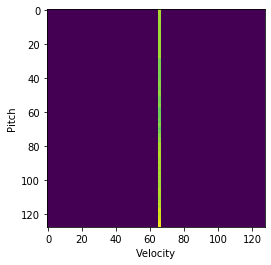

[[0.89198575 0.88729128]
 [0.87704945 0.87235779]
 [0.87952795 0.87483672]
 [0.87094208 0.86625474]
 [0.860827   0.85615287]
 [0.86274352 0.8580649 ]
 [0.86497088 0.86027726]
 [0.86314409 0.85845689]
 [0.86875619 0.86403817]
 [0.85539097 0.85069637]
 [0.86110598 0.8564285 ]
 [0.86386715 0.85916789]
 [0.86307937 0.85840961]
 [0.85688426 0.85218518]
 [0.8645025  0.85982286]
 [0.86643419 0.86175603]
 [0.84954458 0.84484992]
 [0.85111233 0.86011343]
 [0.86025646 0.85559402]
 [0.85600146 0.85131601]
 [0.85800958 0.85337047]
 [0.86156825 0.8568313 ]
 [0.86622637 0.86155101]
 [0.85676796 0.85206986]
 [0.86236098 0.85759857]
 [0.85347215 0.8487729 ]
 [0.86080192 0.85614117]
 [0.87368855 0.86895418]
 [0.87387998 0.86920038]
 [0.80252328 0.79788458]
 [0.80263437 0.79799737]
 [0.79997783 0.79529916]
 [0.80726059 0.80253654]
 [0.80985751 0.80520549]
 [0.80435096 0.7996419 ]
 [0.80950881 0.80480671]
 [0.79733637 0.79256829]
 [0.81571685 0.81102878]
 [0.79553592 0.79090796]
 [0.79865038 0.79401205]


In [42]:
loudness_matrix=np.load(f"Store/Notes/loudness_matrix_{note_length}.npy")

velocities=range(65,67)

# print the loudness matrix for velocity
import matplotlib.pyplot as plt
# xaxis is velocity
# yaxis is pitch
plt.imshow(loudness_matrix)
plt.xlabel("Velocity")
plt.ylabel("Pitch")
plt.show()

# print the loudness matrix for velocity
loudness_matrix_for_velocity=loudness_matrix[:,velocities]
print(loudness_matrix_for_velocity)

In [18]:
midi_file="temp.mid"
# read the midi file
mido_obj = mid_parser.MidiFile(midi_file)

# delete all the notes
for track in mido_obj.instruments:
    track.notes = []

# create a note
note = ct.Note(start=0, end=note_length, pitch=60, velocity=100)

# add the note to the first track
mido_obj.instruments[0].notes.append(note)

# save the file
mido_obj.dump("temp1.mid")

# convert midi to wav
midi2wav("temp1.mid","temp2.wav")

Converting mp3 to wav
Done


'temp2.wav'